### 导入需要的包

In [1]:
import torch
from torch import nn, optim
import torchvision
from d2l import torch as d2l

### 定义device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 定义网络层次结构

In [3]:
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    # (1, 224, 224) -> (96, 54, 54)
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    # (96, 54, 54) -> (96, 26, 26)
    nn.MaxPool2d(kernel_size=3, stride=2),
    # # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    # (96, 26, 26) -> (256, 26, 26)
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    # (256, 26, 26) -> (256, 12, 12)
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    # (256, 12, 12) -> (384, 12, 12)
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    # (384, 12, 12) -> (384, 12, 12)
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    # (384, 12, 12) -> (256, 12, 12)
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    # (256, 12, 12) -> (256, 5, 5)
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

我们构造一个高度和宽度都为224的单通道数据，来观察每一层输出的形状

In [4]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### 读取数据集

尽管原文中AlexNet是在ImageNet上进行训练的，但本书在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，
训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。

将AlexNet直接应用于Fashion-MNIST的一个问题是，Fashion-MNIST图像的分辨率(28 $\times$ 28)像素
低于ImageNet图像。 为了解决这个问题，我们将它们增加到(224 $\times$ 224)像素

通常来讲这不是一个明智的做法，但在这里这样做是为了有效使用AlexNet架构）

In [5]:
def load_data_fashion_mnist(batch_size=128, resize=None, root='../data'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_iter, test_iter

In [6]:
batch_size = 128  # 定义批量大小
resize = 224
root = '../data'  # 定义数据集所在路径

train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, resize=resize, root=root)

定义精读计算函数

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

定义训练函数

In [8]:
def train(net, train_iter, test_iter, num_epochs, device, lr):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform(m.weight) # 对线性层和卷积层进行权重初始化

    net.apply(init_weights)  # net.apply 对网络的每一层应用一遍
    print('training on', device)  # 打印用于训练的是CPU还是GPU
    net.to(device)  # 将网络迁移过去

    optimizer = optim.SGD(net.parameters(), lr=lr)  # SGD optimizer
    loss = nn.CrossEntropyLoss()  # 交叉熵作为损失函数

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

定义学习率、训练轮数

In [9]:
lr = 0.01  # learning rate
num_epochs = 10  # 训练轮数

进行训练:

loss 0.332, train acc 0.879, test acc 0.880
1883.1 examples/sec on cuda


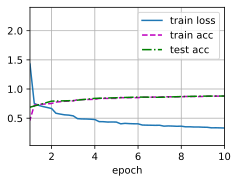

In [10]:
train(net, train_iter, test_iter, num_epochs, device, lr)

更多关于AlexNet的详情可以查看 [origin text](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

讲解可以在李沐老师[《动手学深度学习》](https://zh.d2l.ai/chapter_convolutional-modern/alexnet.html)中查看
